<a href="https://colab.research.google.com/github/eccho03/datamining_project_clothes/blob/main/A_priori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [ ]:
# CSV 파일 읽기
data = pd.read_csv('https://raw.githubusercontent.com/eccho03/datamining_project_clothes/refs/heads/main/size_selection_info.csv')

# 데이터 확인
print(data.head())

   weight   age  height size
0      62  28.0  172.72   XL
1      59  36.0  167.64    L
2      61  34.0  165.10    M
3      65  27.0  175.26    L
4      62  45.0  172.72    M


In [ ]:
num_columns = ['weight', 'age', 'height']
mean = data[num_columns].mean()
std = data[num_columns].std()

# 결과 출력
print("평균")
print(mean)
print("\n표준편차")
print(std)

# 'size'의 범주별 빈도 확인
print("\nSize 빈도수")
print(data['size'].value_counts())

# 데이터 타입 확인
print("데이터 타입")
print(data.dtypes)

# 전체 데이터 요약 정보
print("\n데이터 요약 정보")
print(data.info())

평균
weight     61.756811
age        34.027311
height    165.805794
dtype: float64

표준편차
weight    9.944863
age       8.149447
height    6.737651
dtype: float64

Size 빈도수
size
M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: count, dtype: int64
데이터 타입
weight      int64
age       float64
height    float64
size       object
dtype: object

데이터 요약 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB
None


In [ ]:
# 키와 몸무게를 숫자형으로 변환
data['height'] = pd.to_numeric(data['height'], errors='coerce')
data['weight'] = pd.to_numeric(data['weight'], errors='coerce')

# 결측값 제거
data.dropna(subset=['height', 'weight'], inplace=True)

In [ ]:
# 키 범주화
bins_height = [0, 150, 160, 170, 180, float('inf')]
labels_height = ['height_less_150', 'height_less_160', 'height_less_170', 'height_less_180', 'height_over_180']
data['height_range'] = pd.cut(data['height'], bins=bins_height, labels=labels_height, right=False)

# 몸무게 범주화
bins_weight = [0, 50, 60, 70, 80, float('inf')]
labels_weight = ['weight_less_50', 'weight_less_60', 'weight_less_70', 'weight_less_80', 'weight_over_80']
data['weight_range'] = pd.cut(data['weight'], bins=bins_weight, labels=labels_weight, right=False)

# 사이즈 범주화
size_mapping = {
    'XXS': 'XS', 'XS': 'XS',
    'S': 'S',
    'M': 'M',
    'L': 'L',
    'XL': 'XL', 'XXL': '2XL', 'XXXL': '2XL'
}
data['size_range'] = data['size'].replace(size_mapping)
data['size_range'] = data['size'].replace(size_mapping).fillna('Unknown') # 예외 처리

# 결과 확인
print(data.head())

   weight   age  height size     height_range    weight_range size_range
0      62  28.0  172.72   XL  height_less_180  weight_less_70         XL
1      59  36.0  167.64    L  height_less_170  weight_less_60          L
2      61  34.0  165.10    M  height_less_170  weight_less_70          M
3      65  27.0  175.26    L  height_less_180  weight_less_70          L
4      62  45.0  172.72    M  height_less_180  weight_less_70          M


In [ ]:
# 범주화된 데이터를 트랜잭션으로 변환
transactions = data[['height_range', 'weight_range', 'size_range']].apply(lambda x: set(x), axis=1).tolist()

# 트랜잭션 데이터를 이진화
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------frequent itemsets-----------------
     support                              itemsets
0   0.178989                                 (2XL)
1   0.146804                                   (L)
2   0.248216                                   (M)
3   0.183193                                   (S)
4   0.159668                                  (XL)
5   0.083130                                  (XS)
6   0.147884                     (height_less_160)
7   0.516842                     (height_less_170)
8   0.303122                     (height_less_180)
9   0.403672                      (weight_less_60)
10  0.338163                      (weight_less_70)
11  0.135079                      (weight_less_80)
12  0.083858                (height_less_170, 2XL)
13  0.085642                 (weight_less_80, 2XL)
14  0.097116                   (weight_less_70, L)
15  0.135540                  (height_less_170, M)
16  0.156494                   (weight_less_60, M)
17  0.084093                   

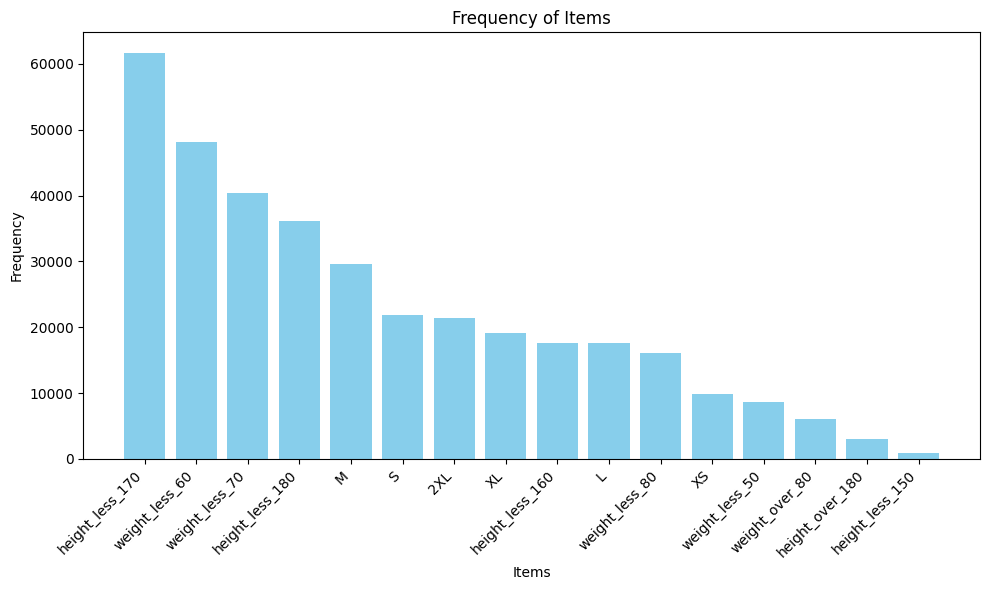

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

frequent_itemsets = apriori(encoded_df, min_support=0.08, use_colnames=True)
print("----------------frequent itemsets-----------------")
print(frequent_itemsets)


# 각 항목별 빈도 계산
item_frequencies = encoded_df.sum().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(item_frequencies.index, item_frequencies.values, color='skyblue')
plt.xlabel('Items', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Frequency of Items', fontsize=12)
plt.xticks(rotation=45, ha='right')  # 항목 이름이 길 경우
plt.tight_layout()
plt.show()

In [ ]:
frequent_itemsets['num_itemsets'] = len(frequent_itemsets)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.08, num_itemsets=frequent_itemsets['num_itemsets'])

print("------------------------------연관 규칙----------------------------\n")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

------------------------------연관 규칙----------------------------

                          antecedents                        consequents  \
0                   (height_less_170)                              (2XL)   
1                               (2XL)                  (height_less_170)   
2                    (weight_less_80)                              (2XL)   
3                               (2XL)                   (weight_less_80)   
4                    (weight_less_70)                                (L)   
5                                 (L)                   (weight_less_70)   
6                   (height_less_170)                                (M)   
7                                 (M)                  (height_less_170)   
8                    (weight_less_60)                                (M)   
9                                 (M)                   (weight_less_60)   
10                   (weight_less_70)                                (M)   
11                     

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
height_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.startswith('height') for item in x))) &
    (rules['consequents'].apply(lambda x: any(item in ['XS', 'S', 'M', 'L', 'XL', '2XL'] for item in x)))
]

print("-------------------------키 -> 사이즈 연관 규칙-----------------------")
print(height_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

-------------------------키 -> 사이즈 연관 규칙-----------------------
                          antecedents          consequents   support  \
0                   (height_less_170)                (2XL)  0.083858   
6                   (height_less_170)                  (M)  0.135540   
13                  (height_less_170)                  (S)  0.101504   
26  (weight_less_60, height_less_170)                  (M)  0.093607   
30                  (height_less_170)  (weight_less_60, M)  0.093607   
33  (weight_less_60, height_less_170)                  (S)  0.084185   
37                  (height_less_170)  (weight_less_60, S)  0.084185   

    confidence      lift  
0     0.162251  0.906486  
6     0.262246  1.056524  
13    0.196393  1.072054  
26    0.385919  1.554772  
30    0.181113  1.157314  
33    0.347075  1.894587  
37    0.162883  1.146886  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
weight_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.startswith('weight_') for item in x))) &
    (rules['consequents'].apply(lambda x: any(item in ['XS', 'S', 'M', 'L', 'XL', '2XL'] for item in x)))
]

print("-------------------------몸무게 -> 사이즈 규칙-------------------------")
print(weight_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

-------------------------몸무게 -> 사이즈 규칙-------------------------
                          antecedents           consequents   support  \
2                    (weight_less_80)                 (2XL)  0.085642   
4                    (weight_less_70)                   (L)  0.097116   
8                    (weight_less_60)                   (M)  0.156494   
10                   (weight_less_70)                   (M)  0.084093   
14                   (weight_less_60)                   (S)  0.142022   
17                   (weight_less_70)                  (XL)  0.101647   
26  (weight_less_60, height_less_170)                   (M)  0.093607   
29                   (weight_less_60)  (height_less_170, M)  0.093607   
33  (weight_less_60, height_less_170)                   (S)  0.084185   
35                   (weight_less_60)  (S, height_less_170)  0.084185   

    confidence      lift  
2     0.634013  3.542192  
4     0.287186  1.956254  
8     0.387676  1.561850  
10    0.248675  1.001849

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 키, 몸무게 -> 사이즈 연관 규칙
height_weight_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.startswith('height_') or item.startswith('weight_') for item in x))) &  # 키와 몸무게 관련 항목
    (rules['consequents'].apply(lambda x: any(item in ['XS', 'S', 'M', 'L', 'XL', '2XL'] for item in x)))  # 사이즈 관련 항목
]

print("------------------------- (키, 몸무게) -> 사이즈 규칙-------------------------")
print(height_weight_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

------------------------- (키, 몸무게) -> 사이즈 규칙-------------------------
                          antecedents           consequents   support  \
0                   (height_less_170)                 (2XL)  0.083858   
2                    (weight_less_80)                 (2XL)  0.085642   
4                    (weight_less_70)                   (L)  0.097116   
6                   (height_less_170)                   (M)  0.135540   
8                    (weight_less_60)                   (M)  0.156494   
10                   (weight_less_70)                   (M)  0.084093   
13                  (height_less_170)                   (S)  0.101504   
14                   (weight_less_60)                   (S)  0.142022   
17                   (weight_less_70)                  (XL)  0.101647   
26  (weight_less_60, height_less_170)                   (M)  0.093607   
29                   (weight_less_60)  (height_less_170, M)  0.093607   
30                  (height_less_170)   (weight_less_6

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
